In [1]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking-GNN

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/tracking-GNN


/home1/giorgian/anaconda3/envs/jupyter/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from dataclasses import replace
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import os.path
import sys
import logging
import pickle
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from models.agnn_inference import GNNSegmentClassifier
from numpy.linalg import inv
import sklearn.metrics as metrics
from datasets import get_data_loaders
from tqdm.notebook import tqdm
from itertools import islice

In [3]:
DEVICE = "cuda:0"

In [4]:
model_result_folder = '../tracking_results/agnn/agnn-lr0.003039158491105233-b12-d64-PReLU-gi3-ln-True-n40000/experiment_2024-11-09_23:30:24'
config_file = model_result_folder + '/config.pkl'
config = pickle.load(open(config_file, 'rb'))
data_config = config.get('data')
dphi_max, dz_max = data_config['phi_slope_max'], data_config['z0_max']

model_config = config.get('model', {})
model_config.pop('loss_func')
model_config.pop('name')
model = GNNSegmentClassifier(**model_config).to(DEVICE)

def load_checkpoint(checkpoint_file, model, optimizer=None):
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

# load_checkpoint
checkpoint_dir = os.path.join(model_result_folder, 'checkpoints')
checkpoint_file = sorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('model_checkpoint')])
checkpoint_file = checkpoint_file[-1]
print(checkpoint_file)
model = load_checkpoint(checkpoint_file, model)
print('Successfully reloaded!')

../tracking_results/agnn/agnn-lr0.003039158491105233-b12-d64-PReLU-gi3-ln-True-n40000/experiment_2024-11-09_23:30:24/checkpoints/model_checkpoint_006.pth.tar
Successfully reloaded!


/tmp/ipykernel_1745742/3046734684.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))


In [5]:
data_config['input_dir'] = '/ssd3/giorgian/hits-data-september-run2024pp/0/'
data_config['n_folders'] = 1
data_config['n_mix'] = 1
data_config['n_train'] = 13955
data_config['n_valid'] = 0
data_config['batch_size'] = 1

In [5]:
data_config

{'batch_size': 1,
 'construct_edges': False,
 'input_dir': '/ssd3/giorgian/hits-data-september-run2024pp/0/',
 'input_dir2': '/ssd2/giorgian/hits-data-august-2022/nontrigger/0/',
 'load_full_event': False,
 'n_folders': 1,
 'n_mix': 1,
 'n_train': 13955,
 'n_valid': 0,
 'n_workers': 16,
 'name': 'hit_graph_trigger_pileup',
 'phi_slope_max': 0.012193355583173944,
 'real_weight': 1,
 'z0_max': 14.220353082111805}

In [6]:
train_data_loader, valid_data_loader = get_data_loaders(distributed=False, rank=0, n_ranks=0, **data_config)


In [28]:
td = iter(train_data_loader)

Process Process-21:
Process Process-23:
Process Process-28:
Process Process-27:
Process Process-24:
Process Process-25:
Process Process-19:
Process Process-26:
Process Process-17:
Process Process-22:
Process Process-20:
Process Process-29:
Process Process-18:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home1/giorgian/anaconda3/envs/jupyter/lib/python3.12/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home1/giorgian/anaconda3/envs/jupyter/lib/python3.12/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/home1/giorgian/anaconda3/envs

In [19]:
batch.filename

['/ssd3/giorgian/hits-data-september-run2024pp/0/event-100006315.npz']

In [11]:
dzs = []
for batch in tqdm(islice(train_data_loader, 1000), total=1000):
    batch = batch.to(DEVICE)
    f = np.load(batch.filename[0])
    hits = f['hit_cartesian']
    pred = model((batch.x, batch.edge_index))
    start, end = batch.edge_index
    
    for i, (u, v) in enumerate(zip(start, end)):
        h1 = hits[u]
        h2 = hits[v]
        p = pred[i] > 0.5
        if p:
            dzs.append(h1[-1] - h2[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'count')

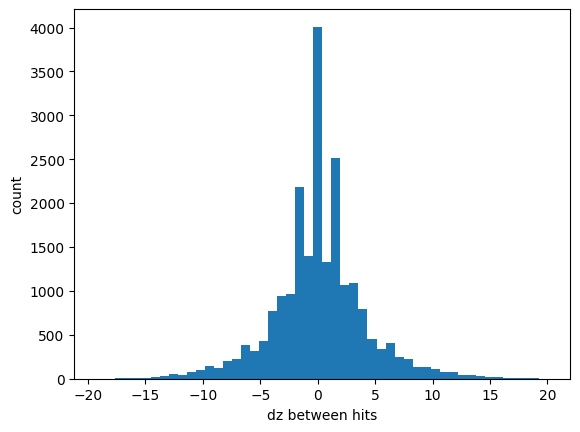

In [10]:
plt.hist(dzs, bins=50)
plt.xlabel('dz between hits')
plt.ylabel('count')

In [12]:
dzs = []
for batch in tqdm(islice(train_data_loader, 1000), total=1000):
    batch = batch.to(DEVICE)
    f = np.load(batch.filename[0])
    hits = f['hit_cartesian']
    pred = model((batch.x, batch.edge_index))
    start, end = batch.edge_index
    
    for i, (u, v) in enumerate(zip(start, end)):
        h1 = hits[u]
        h2 = hits[v]
        p = pred[i] < 0.5
        if p:
            dzs.append(h1[-1] - h2[-1])

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'count')

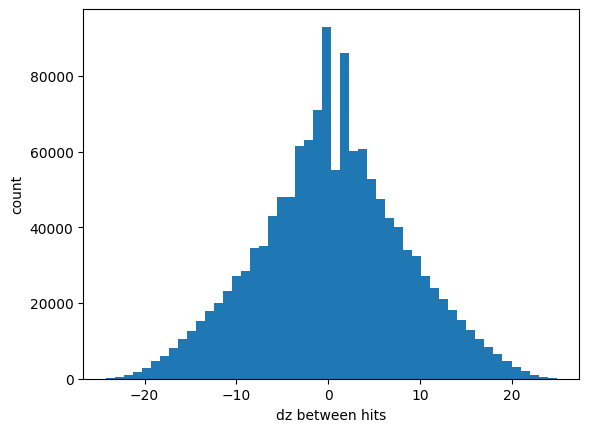

In [14]:
plt.hist(dzs, bins=50)
plt.xlabel('dz between hits')
plt.ylabel('count')

In [16]:
dzs = []
for batch in tqdm(islice(train_data_loader, 1000), total=1000):
    batch = batch.to(DEVICE)
    f = np.load(batch.filename[0])
    hits = f['hit_cartesian']
    pred = model((batch.x, batch.edge_index))
    start, end = batch.edge_index
    
    for i, (u, v) in enumerate(zip(start, end)):
        h1 = hits[u]
        h2 = hits[v]
        p = pred[i] >= 0.5
        if p:
            dzs.append(h1[-1] - h2[-1])

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'count')

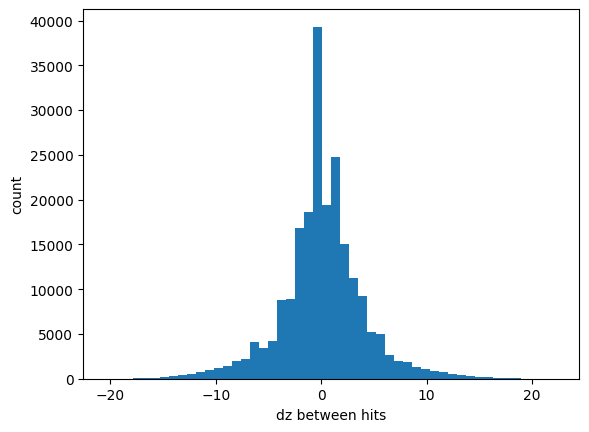

In [17]:
plt.hist(dzs, bins=50)
plt.xlabel('dz between hits')
plt.ylabel('count')

(-10.0, 10.0)

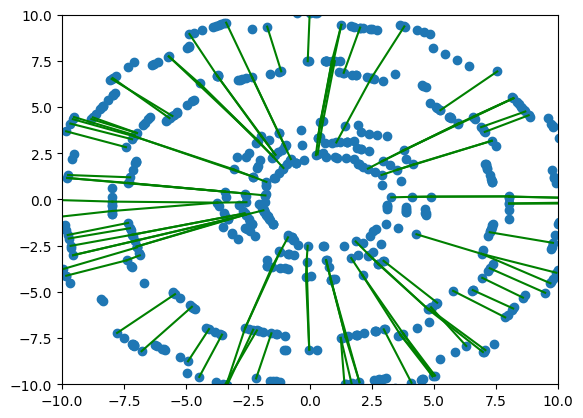

In [40]:
batch = next(td)
batch = batch.to(DEVICE)
f = np.load(batch.filename[0])
hits = f['hit_cartesian']
pred = model((batch.x, batch.edge_index))
plt.scatter(hits[:, 0], hits[:, 1])
start, end = batch.edge_index

for i, (u, v) in enumerate(zip(start, end)):
    h1 = hits[u]
    h2 = hits[v]
   #print(f'{h1[0]=} {h2[0]=} {h1[1]=} {h2[1]=}')
    p = pred[i] > 0.5
    if p:
        # true positive
        plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='green')
    else:
        pass
        #plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='black')

        

plt.xlim([-10, 10])
plt.ylim([-10, 10])


(-10.0, 10.0)

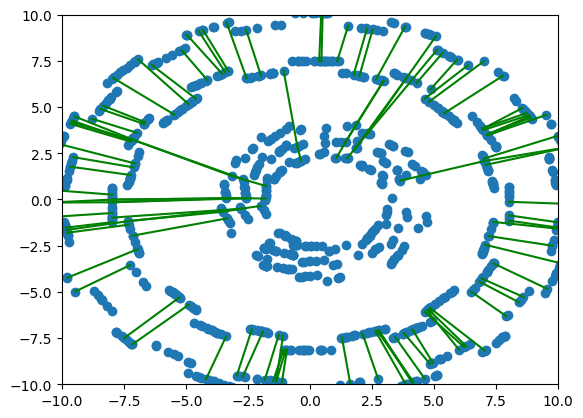

In [39]:
batch = next(td)
batch = batch.to(DEVICE)
f = np.load(batch.filename[0])
hits = f['hit_cartesian']
pred = model((batch.x, batch.edge_index))
plt.scatter(hits[:, 0], hits[:, 1])
start, end = batch.edge_index

for i, (u, v) in enumerate(zip(start, end)):
    h1 = hits[u]
    h2 = hits[v]
   #print(f'{h1[0]=} {h2[0]=} {h1[1]=} {h2[1]=}')
    p = pred[i] > 0.5
    if p:
        # true positive
        plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='green')
    else:
        pass
        #plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='black')

        

plt.xlim([-10, 10])
plt.ylim([-10, 10])


(-10.0, 10.0)

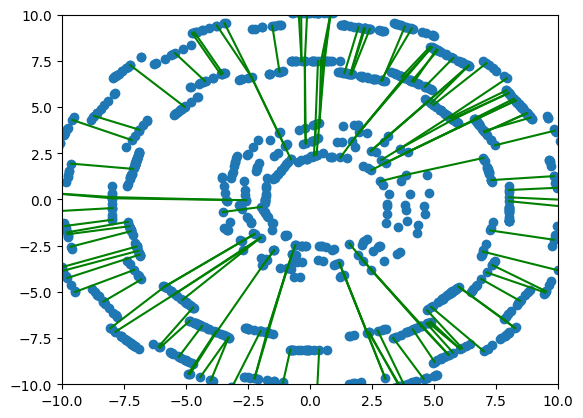

In [41]:
batch = next(td)
batch = batch.to(DEVICE)
f = np.load(batch.filename[0])
hits = f['hit_cartesian']
pred = model((batch.x, batch.edge_index))
plt.scatter(hits[:, 0], hits[:, 1])
start, end = batch.edge_index

for i, (u, v) in enumerate(zip(start, end)):
    h1 = hits[u]
    h2 = hits[v]
   #print(f'{h1[0]=} {h2[0]=} {h1[1]=} {h2[1]=}')
    p = pred[i] > 0.5
    if p:
        # true positive
        plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='green')
    else:
        pass
        #plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='black')

        

plt.xlim([-10, 10])
plt.ylim([-10, 10])


(-10.0, 10.0)

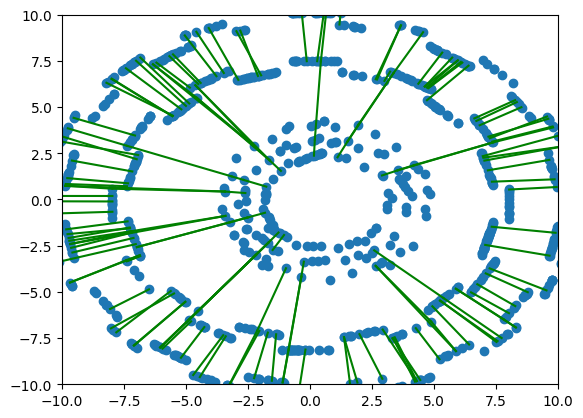

In [42]:
batch = next(td)
batch = batch.to(DEVICE)
f = np.load(batch.filename[0])
hits = f['hit_cartesian']
pred = model((batch.x, batch.edge_index))
plt.scatter(hits[:, 0], hits[:, 1])
start, end = batch.edge_index

for i, (u, v) in enumerate(zip(start, end)):
    h1 = hits[u]
    h2 = hits[v]
   #print(f'{h1[0]=} {h2[0]=} {h1[1]=} {h2[1]=}')
    p = pred[i] > 0.5
    if p:
        # true positive
        plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='green')
    else:
        pass
        #plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='black')

        

plt.xlim([-10, 10])
plt.ylim([-10, 10])
